In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV



In [36]:
data_clean = pd.read_csv("E:\My_Projects\Data_Science_Projects\Employee Performance_Analysis\Data\processed")

print(data_clean.head()) 

   Age  Gender  EducationBackground  MaritalStatus  EmpDepartment  \
0   32       0                    2              2              5   
1   47       0                    2              2              5   
2   40       0                    1              1              5   
3   41       0                    0              0              3   
4   60       0                    2              2              5   

   BusinessTravelFrequency  DistanceFromHome  EmpEducationLevel  \
0                        2                10                  3   
1                        2                14                  4   
2                        1                 5                  4   
3                        2                10                  4   
4                        2                16                  4   

   EmpEnvironmentSatisfaction  EmpHourlyRate  ...  \
0                           4             55  ...   
1                           4             42  ...   
2                      

In [ ]:
# ===== Preprocessing: Re-map target variable =====
# Our original target values are [2,3,4]. For models like XGBoost, I remap them to [0,1,2].
data_processed = data_clean.copy()  # Work on a copy of your data
data_processed['PerformanceRating'] = data_processed['PerformanceRating'].map({2: 0, 3: 1, 4: 2})

# ===== Prepare Numeric Columns =====
# Defined the list of numeric columns for scaling/normalization.
numeric_cols = [
    'NumCompaniesWorked', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear',
    'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole','EmpEnvironmentSatisfaction',
    'EmpLastSalaryHikePercent', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'EmpHourlyRate','EmpJobRole_Developer', 'EmpWorkLifeBalance', 'OverTime',
    'EmpJobRole_Technical Lead'
]

# Remove any column that is constant (only one unique value) because they don’t add any information.
numeric_cols = [col for col in numeric_cols if data_processed[col].nunique() > 1]
print("Final numeric columns for scaling:", numeric_cols)

# ===== Separate Features and Target =====
X = data_processed.drop(columns=['PerformanceRating'])
y = data_processed['PerformanceRating']

# ===== Preprocessing Pipeline for Numeric Columns =====
# I apply StandardScaler to the numeric columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'  # leave other columns unchanged
)

# ===== Build the Overall Pipeline =====
# I include scaling, feature selection, and polynomial feature expansion.
pipeline = Pipeline([
    ('scaling', Pipeline([
        ('preprocessor', preprocessor)
    ])),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('feature_engineering', PolynomialFeatures(degree=2, include_bias=False)),
    # The final classifier is a placeholder that will be set via GridSearchCV.
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# ===== Split the Data =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Initial Training & Evaluation with RandomForest =====
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("RandomForest Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ===== Model Comparison via GridSearchCV =====
# I try four classifiers: RandomForest, LogisticRegression, SVM, and XGBoost.
# Note: For LogisticRegression, I increased max_iter to 500.
param_grid = {
    'classifier': [
        RandomForestClassifier(n_estimators=100, random_state=42),
        LogisticRegression(max_iter=500, random_state=42),
        SVC(probability=True, random_state=42),
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    ]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_train, y_train)

print("Best Model:", grid.best_estimator_)
print("Best Accuracy (cv):", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Test Set Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Final numeric columns for scaling: ['NumCompaniesWorked', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EmpHourlyRate', 'EmpJobRole_Developer', 'EmpWorkLifeBalance', 'OverTime']


c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


RandomForest Classifier Accuracy: 0.9017857142857143
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.95      0.93      0.94       167
           2       0.88      0.71      0.79        21

    accuracy                           0.90       224
   macro avg       0.86      0.84      0.84       224
weighted avg       0.91      0.90      0.90       224



c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c

Best Model: Pipeline(steps=[('scaling',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['NumCompaniesWorked',
                                                                    'TotalWorkExperienceInYears',
                                                                    'TrainingTimesLastYear',
                                                                    'ExperienceYearsAtThisCompany',
                                                                    'ExperienceYearsInCurrentRole',
                                                                    'EmpEnvironmentSatisfaction',
                                                                    'EmpLastSalaryHikePercent',

In [ ]:
# ===== Preprocessing: Re-map target variable =====
# Our original target values are [2,3,4]. For models like XGBoost, I remap them to [0,1,2].
data_processed = data_clean.copy()  # Work on a copy of your data
data_processed['PerformanceRating'] = data_processed['PerformanceRating'].map({2: 0, 3: 1, 4: 2})

# ===== Prepare Numeric Columns =====
# Define the list of numeric columns for scaling/normalization.
numeric_cols = [
    'NumCompaniesWorked', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear',
    'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole','EmpEnvironmentSatisfaction',
    'EmpLastSalaryHikePercent', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
    'EmpHourlyRate','EmpJobRole_Developer', 'EmpWorkLifeBalance', 'OverTime',
    'EmpJobRole_Technical Lead'
]

# Remove any column that is constant (only one unique value) because they don’t add any information.
numeric_cols = [col for col in numeric_cols if data_processed[col].nunique() > 1]
print("Final numeric columns for scaling:", numeric_cols)

# ===== Separate Features and Target =====
X = data_processed.drop(columns=['PerformanceRating'])
y = data_processed['PerformanceRating']

# ===== Preprocessing Pipeline for Numeric Columns =====
# I apply StandardScaler to the numeric columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'  # leave other columns unchanged
)

# ===== Build the Overall Pipeline =====
# I include scaling, feature selection, and polynomial feature expansion.
pipeline = Pipeline([
    ('scaling', Pipeline([
        ('preprocessor', preprocessor)
    ])),
    ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ('feature_engineering', PolynomialFeatures(degree=2, include_bias=False)),
    # The final classifier is a placeholder that will be set via GridSearchCV.
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# ===== Split the Data =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Initial Training & Evaluation with RandomForest =====
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("RandomForest Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ===== Model Comparison via GridSearchCV =====
# I try four classifiers: RandomForest, LogisticRegression, SVM, and XGBoost.
# Note: For LogisticRegression, I increased max_iter to 500.
param_grid = {
    'classifier': [
        RandomForestClassifier(n_estimators=100, random_state=42),
        LogisticRegression(max_iter=500, random_state=42),
        SVC(probability=True, random_state=42),
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    ]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_train, y_train)

print("Best Model:", grid.best_estimator_)
print("Best Accuracy (cv):", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Test Set Accuracy of Best Model:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Final numeric columns for scaling: ['NumCompaniesWorked', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EmpHourlyRate', 'EmpJobRole_Developer', 'EmpWorkLifeBalance', 'OverTime']


c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


RandomForest Classifier Accuracy: 0.9017857142857143
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.95      0.93      0.94       167
           2       0.88      0.71      0.79        21

    accuracy                           0.90       224
   macro avg       0.86      0.84      0.84       224
weighted avg       0.91      0.90      0.90       224



c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c

Best Model: Pipeline(steps=[('scaling',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['NumCompaniesWorked',
                                                                    'TotalWorkExperienceInYears',
                                                                    'TrainingTimesLastYear',
                                                                    'ExperienceYearsAtThisCompany',
                                                                    'ExperienceYearsInCurrentRole',
                                                                    'EmpEnvironmentSatisfaction',
                                                                    'EmpLastSalaryHikePercent',

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))


Class distribution before SMOTE: Counter({1: 648, 0: 147, 2: 99})
Class distribution after SMOTE: Counter({1: 648, 2: 648, 0: 648})


In [8]:
RandomForestClassifier(class_weight='balanced', random_state=42)


RandomForestClassifier(class_weight='balanced', random_state=42)


The model is already performing well, with around 90% accuracy on the test set. However, there's still room for improvement, particularly in improving recall for class 2 and generalizing the model for unseen data. Below are several steps to enhance your model output:

1. Improve Class Balance (Handle Class 2 Recall)
🔹 Problem: Class 2 has lower recall, meaning the model is missing some true positives. This could be due to class imbalance.
✅ Solution:
Try SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic examples for underrepresented classes.
Use Class Weights in RandomForestClassifier to give more importance to class 2.
Implementation
python
Copy
Edit
from imblearn.over_sampling import SMOTE
from collections import Counter

# Before SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# After SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))
Then, fit the model using X_train_resampled and y_train_resampled instead of X_train and y_train.

Alternatively, modify RandomForestClassifier to penalize misclassifications of minority classes:


RandomForestClassifier(class_weight='balanced', random_state=42)
2. Feature Engineering Improvements
🔹 Problem: The PolynomialFeatures step might be adding unnecessary complexity.
✅ Solution:
Try Interaction Features Instead of full polynomial expansion.
Use Feature Importances from RandomForest to drop irrelevant features.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Generate interaction features only (avoid full polynomial expansion)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


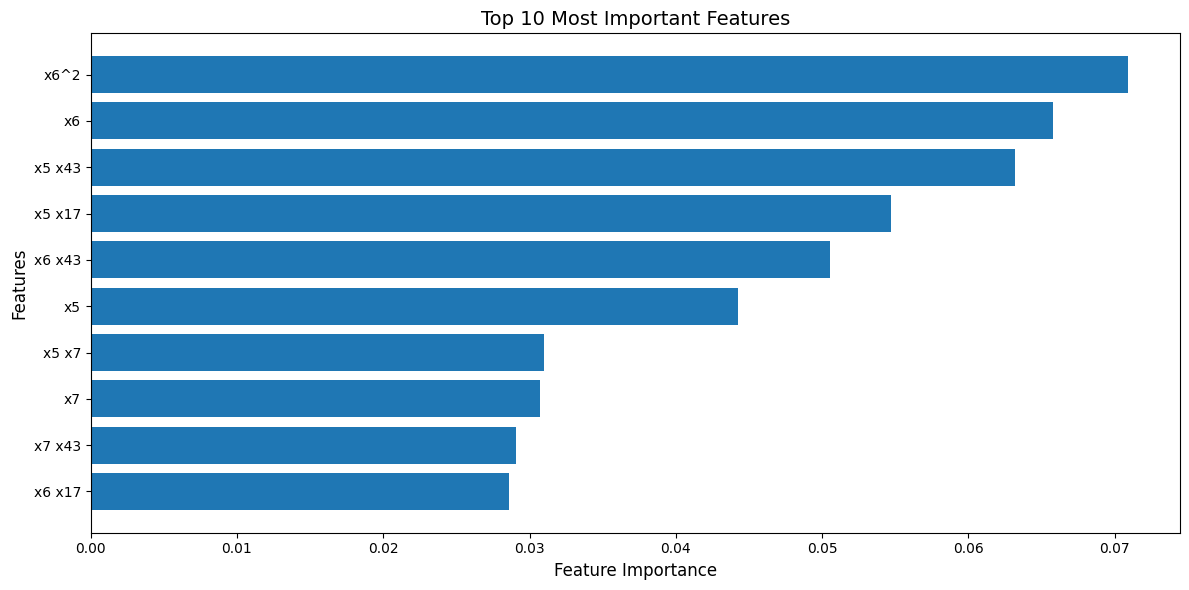

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get transformed feature names (after PolynomialFeatures)
feature_engineering = best_model.named_steps['feature_engineering']
feature_selection = best_model.named_steps['feature_selection']
selected_feature_names = feature_selection.get_feature_names_out()
poly_feature_names = feature_engineering.get_feature_names_out(selected_feature_names)

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
n_features_to_plot = min(10, len(feature_importances))

# Plot
plt.figure(figsize=(12, 6))
plt.barh(np.array(poly_feature_names)[sorted_idx[:n_features_to_plot]], 
         feature_importances[sorted_idx[:n_features_to_plot]])

plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title(f"Top {n_features_to_plot} Most Important Features", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()

# **Fix label display**
plt.tight_layout()  # Adjust layout
plt.show()


In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(5, 50),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)


c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best Parameters: {'classifier__max_depth': 48, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 326}
Best CV Accuracy: 0.9306258238654197


In [12]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

for name, model in models.items():
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))


c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Model: RandomForest
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.95      0.93      0.94       167
           2       0.88      0.71      0.79        21

    accuracy                           0.90       224
   macro avg       0.86      0.84      0.84       224
weighted avg       0.91      0.90      0.90       224



c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\user\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        36
           1       0.96      0.89      0.92       167
           2       0.68      0.81      0.74        21

    accuracy                           0.88       224
   macro avg       0.78      0.86      0.82       224
weighted avg       0.89      0.88      0.88       224



c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Model: CatBoost
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        36
           1       0.94      0.91      0.93       167
           2       0.76      0.76      0.76        21

    accuracy                           0.89       224
   macro avg       0.81      0.84      0.83       224
weighted avg       0.89      0.89      0.89       224

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4948
[LightGBM] [Info] Number of data points in the train set: 894, number of used features: 65
[LightGBM] [Info] Start training from score -1.805273
[LightGBM] [Info] Start training from score -0.321815
[LightGBM] [Info] Start training from score -2.200586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [42 44] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\user\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Model: LightGBM
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        36
           1       0.96      0.91      0.93       167
           2       0.73      0.76      0.74        21

    accuracy                           0.89       224
   macro avg       0.81      0.85      0.83       224
weighted avg       0.90      0.89      0.90       224



In [13]:

from scipy.stats import randint
from sklearn.metrics import classification_report
#{'classifier__max_depth': 48, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 326}

def tune_hyperparameters(pipeline, X_train, y_train, n_iter=30, cv=5):
    """Performs hyperparameter tuning using RandomizedSearchCV."""
    param_dist = {
                'classifier__n_estimators': randint(100, 326),  # Specify a range
                'classifier__max_depth': randint(1, 48),
                'classifier__min_samples_split': randint(2, 20),  
                'classifier__min_samples_leaf': randint(1, 10),  

    }

    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter,
        cv=cv, scoring='accuracy', n_jobs=-1, random_state=42
    )
    random_search.fit(X_train, y_train)
    print("Best Parameters:", random_search.best_params_)
    print("Best CV Accuracy:", random_search.best_score_)
    return random_search.best_estimator_

def evaluate_models(models, pipeline, X_train, X_test, y_train, y_test):
    """Fits different models using the given pipeline and evaluates their performance."""
    results = {}
    for name, model in models.items():
        pipeline.set_params(classifier=model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        results[name] = classification_report(y_test, y_pred, output_dict=True)
        print(f"Model: {name}")
        print(classification_report(y_test, y_pred))
    return results

# Define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# Define the optimized pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [15]:
def evaluate_models(models, pipeline, X_train, X_test, y_train, y_test):
    """Fits different models using the given pipeline and evaluates their performance."""
    results = {}
    for name, model in models.items():
        pipeline.set_params(classifier=model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        weighted_avg = report.get("weighted avg", {})

        results[name] = {
            "accuracy": report.get("accuracy", 0),  # Accuracy is a float, not a dict
            "precision": weighted_avg.get("precision", 0),
            "recall": weighted_avg.get("recall", 0),
            "f1-score": weighted_avg.get("f1-score", 0)
        }
        
        print(f"Model: {name}")
        print(classification_report(y_test, y_pred))
    
    return results


In [16]:
def plot_model_performance(results):
    """Plots the classification performance metrics for different models."""
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    model_names = list(results.keys())
    
    # Extract only the necessary values
    scores = {metric: [results[model][metric] for model in model_names] for metric in metrics}
    
    df = pd.DataFrame(scores, index=model_names)

    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.show()


Model: RandomForest
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        36
           1       0.95      0.95      0.95       167
           2       0.83      0.71      0.77        21

    accuracy                           0.92       224
   macro avg       0.87      0.85      0.86       224
weighted avg       0.92      0.92      0.92       224

Model: XGBoost
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        36
           1       0.96      0.92      0.94       167
           2       0.71      0.81      0.76        21

    accuracy                           0.90       224
   macro avg       0.81      0.86      0.84       224
weighted avg       0.90      0.90      0.90       224

Model: CatBoost
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        36
           1       0.96      0.93      0.95       167
           2       0.77 

<Figure size 1000x600 with 0 Axes>

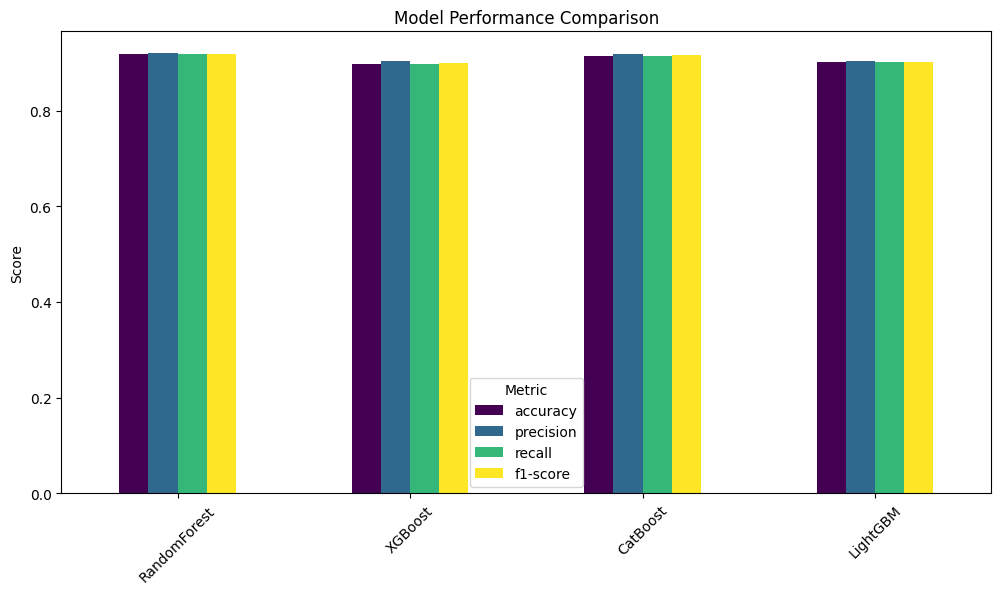

In [17]:
results = evaluate_models(models, pipeline, X_train, X_test, y_train, y_test)
plot_model_performance(results)


In [18]:
models["XGBoost"] = XGBClassifier(eval_metric='mlogloss', random_state=42)
models["LightGBM"] = LGBMClassifier(min_data_in_leaf=10, random_state=42)


In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define base estimators with tuned hyperparameters (adjust as needed)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=269, max_depth=11, 
                                   max_features=None, min_samples_leaf=3, 
                                   min_samples_split=3, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42)),
    ('cat', CatBoostClassifier(verbose=0, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Create the StackingClassifier with Logistic Regression as the final estimator.
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, random_state=42),
    cv=5,
    n_jobs=-1
)

# Train and evaluate the stacking ensemble.
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

print("Stacking Ensemble Performance:")
print(classification_report(y_test, y_pred_stacking))


Stacking Ensemble Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        36
           1       0.96      0.96      0.96       167
           2       0.89      0.81      0.85        21

    accuracy                           0.93       224
   macro avg       0.89      0.89      0.89       224
weighted avg       0.93      0.93      0.93       224



In [34]:
# Get the number of features in the stacking model
n_features_stack = len(estimators)

print(f"Number of features in the stacking model: {n_features_stack}")


Number of features in the stacking model: 4


In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Define base estimators (using same tuned models as above)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=269, max_depth=11, 
                                   max_features=None, min_samples_leaf=3, 
                                   min_samples_split=3, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42)),
    ('cat', CatBoostClassifier(verbose=0, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Create the VotingClassifier with soft voting.
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',  # 'soft' voting averages probabilities
    n_jobs=-1
)

# Train and evaluate the voting ensemble.
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

print("Voting Ensemble Performance:")
print(classification_report(y_test, y_pred_voting))


Voting Ensemble Performance:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        36
           1       0.96      0.94      0.95       167
           2       0.81      0.81      0.81        21

    accuracy                           0.92       224
   macro avg       0.86      0.88      0.87       224
weighted avg       0.92      0.92      0.92       224



In [22]:
import numpy as np
from sklearn.metrics import classification_report

def blend_ensemble(models, X, weights):
    """
    models: list of trained models that implement predict_proba
    weights: list of weights (should sum to 1)
    Returns the blended class predictions.
    """
    # Initialize an array for blended probabilities
    blended_prob = None
    for model, weight in zip(models, weights):
        prob = model.predict_proba(X)
        if blended_prob is None:
            blended_prob = weight * prob
        else:
            blended_prob += weight * prob
    # Choose the class with the highest probability for each sample
    return np.argmax(blended_prob, axis=1)

# Assume you have individually tuned and trained models:
rf_model = RandomForestClassifier(n_estimators=269, max_depth=11, 
                                  max_features=None, min_samples_leaf=3, 
                                  min_samples_split=3, random_state=42).fit(X_train, y_train)
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42).fit(X_train, y_train)
cat_model = CatBoostClassifier(verbose=0, random_state=42).fit(X_train, y_train)
lgbm_model = LGBMClassifier(random_state=42).fit(X_train, y_train)

# List of models and equal weights for blending
models_list = [rf_model, xgb_model, cat_model, lgbm_model]
weights = [0.25, 0.25, 0.25, 0.25]

# Compute blended predictions
y_pred_blend = blend_ensemble(models_list, X_test, weights)

print("Blended Ensemble Performance:")
print(classification_report(y_test, y_pred_blend))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 894, number of used features: 38
[LightGBM] [Info] Start training from score -1.805273
[LightGBM] [Info] Start training from score -0.321815
[LightGBM] [Info] Start training from score -2.200586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [23]:
import joblib

# Save the trained stacking model
joblib.dump(stacking_clf, r"E:\My_Projects\Data_Science_Projects\Employee Performance_Analysis\src\models\final_model_stacking.pkl")

print("Final stacking model saved successfully.")


Final stacking model saved successfully.


In [33]:
joblib.dump(blend_ensemble, r"E:\My_Projects\Data_Science_Projects\Employee Performance_Analysis\src\models\blend_ensemble.pkl")
joblib.dump(voting_clf, r"E:\My_Projects\Data_Science_Projects\Employee Performance_Analysis\src\models\voting_clf.pkl")

['E:\\My_Projects\\Data_Science_Projects\\Employee Performance_Analysis\\src\\models\\voting_clf.pkl']

In [ ]:
import os

# Define the directory path
directory = r"E:\My_Projects\Data_Science_Projects\Employee Performance_Analysis\Data"

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Now, save the files
X_test.to_csv(f"{directory}/X_test.csv", index=False)
y_test.to_csv(f"{directory}/y_test.csv", index=False)

print("Test data saved successfully!")


Test data saved successfully!


In [35]:
import pandas as pd

# Fit the stacking model (already done in your case)
stacking_clf.fit(X_train, y_train)

# Extract base model feature importances
base_model_importances = {}

# Loop over base estimators in the stacking model
for name, model in stacking_clf.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):  # Check if the model has feature importances
        base_model_importances[name] = model.feature_importances_

# Check if I have feature importances for any base model
if base_model_importances:
    for model_name, feature_importances in base_model_importances.items():
        # Ensure feature names match the data used for training
        if hasattr(stacking_clf, 'named_steps'):
            preprocessor = stacking_clf.named_steps['preprocessor']  # Assuming you have a preprocessor
            feature_names = preprocessor.get_feature_names_out()
        else:
            feature_names = X_train.columns  # Ensure this is the same data used for training

        # Ensure lengths match
        if len(feature_importances) == len(feature_names):
            fi_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': feature_importances
            }).sort_values(by='Importance', ascending=False)

            print(f"\nTop 3 Important Features for {model_name}:")
            print(fi_df.head(3))
        else:
            print(f"Mismatch detected in feature importances for {model_name}. Check preprocessing steps.")
else:
    print("No feature importances found for base models in the stacking ensemble.")



Top 3 Important Features for rf:
                       Feature  Importance
8   EmpEnvironmentSatisfaction    0.245770
15    EmpLastSalaryHikePercent    0.244717
22     YearsSinceLastPromotion    0.201860

Top 3 Important Features for xgb:
                       Feature  Importance
8   EmpEnvironmentSatisfaction    0.170982
15    EmpLastSalaryHikePercent    0.138122
22     YearsSinceLastPromotion    0.135999

Top 3 Important Features for cat:
                       Feature  Importance
8   EmpEnvironmentSatisfaction   25.769009
15    EmpLastSalaryHikePercent   19.319589
22     YearsSinceLastPromotion   13.591655

Top 3 Important Features for lgbm:
               Feature  Importance
9        EmpHourlyRate         974
43    Mahalanobis_Dist         874
19  EmpWorkLifeBalance         854
